In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append(os.path.dirname(os.path.abspath('.')))

In [2]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import random
from tqdm.notebook import tqdm

# Load Tiktok

In [3]:
transform_dict = {
    'nauseated_face':'Nauseated-face', 
    'slightly_smiling_face':'Smiling',
    'grinning_face_with_clenched_teeth':'Clenched-teeth',# ********
    'clenched_teeth':'Clenched-teeth',
    'sad':'Sad',
    'cry':'Cry',
    'ready':None,
    'crying_face':'Cry',
    'grinning_face_with_normal_eyes':'Smiling',
    'disappointed_face':'Disappointed',
    'here_we_go':None,
    'surprise':'Surprise',
    'eye_roll':'Eye-roll',
    'angry':'Angry',
    'who_can_make_the_best_emoji_face':None,
    'disgust':'Disgust',
    'thinking_face':'Thinking face',
    'try_to_make_a_face_that_fits_my_description':None,
    'angry_face':'Angry',
    'face_challenge':None,
    'winking_face':'Winking face',
    'cringe':'Cringe',
    'kiss':'Kiss',
    'clown_face': 'Clown-face'
}

def load_tiktok():
    src = 'face_challenge'
    dataset = []
    for expr in os.listdir(src):
        dataset.extend([(expr,'/'.join([src,expr,x])) for x in os.listdir('/'.join([src,expr]))])
    df = pd.DataFrame(dataset, columns=['emotion','address'])
    df['vid_id'] = df.address.apply(lambda x: x.split('/')[-1].split('_')[0])
    return df

tiktok_df = load_tiktok()
tiktok_df.emotion = tiktok_df.emotion.apply(lambda x:transform_dict[x])
tiktok_df = tiktok_df.dropna().reset_index(drop=True)
tiktok_df['label'] = tiktok_df.emotion.astype('category').cat.codes
global_emotions = list(tiktok_df.emotion.unique())
val_ids = tiktok_df.vid_id.sample(1000).to_list()
val_df = tiktok_df[tiktok_df.vid_id.isin(val_ids)].reset_index(drop=True)
train_df = tiktok_df[~tiktok_df.vid_id.isin(val_ids)].reset_index(drop=True)
print(len(train_df), len(val_df))
assert len(train_df.emotion.unique()) == len(global_emotions) 
assert len(val_df.emotion.unique()) == len(global_emotions) 
ekman = ['Sad','Surprise','Angry','Disgust','Smiling']


109949 21288


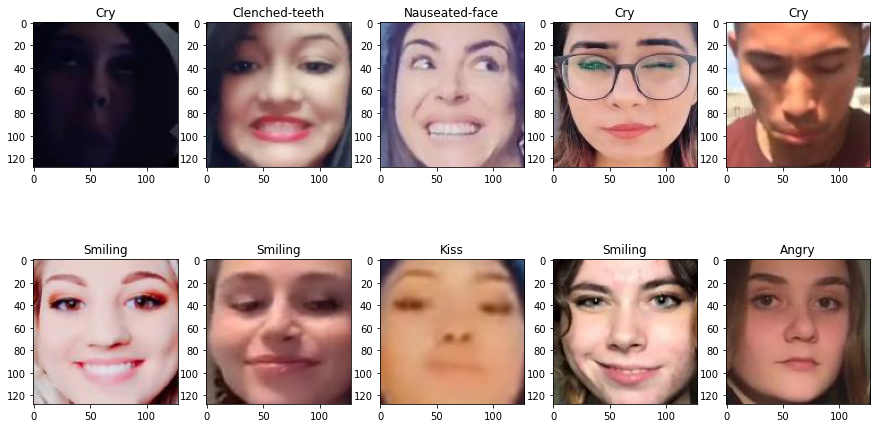

In [4]:
plt.figure(figsize=(15,8))
for i, (_, row) in enumerate(tiktok_df.sample(10).iterrows()):
    image = plt.imread(row.address)
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.title(row.emotion)

# Dataset stats

In [5]:
counter = Counter(train_df.label)
stats_df = pd.DataFrame({'emotion':global_emotions, 'count':[counter[x] for x in range(len(counter))]})
stats_df['weight'] = stats_df['count'].sum()/stats_df['count']**0.5
stats_df['weight'] /= stats_df['weight'].max()
display(stats_df)
weights = stats_df['weight'].to_numpy()

,emotion,count,weight
0,Nauseated-face,12537,0.207539
1,Smiling,12635,0.206733
2,Clenched-teeth,540,1.000000
3,Sad,4763,0.336710
4,Cry,11737,0.214496
5,Disappointed,7848,0.262312
6,Surprise,4759,0.336852
7,Eye-roll,4762,0.336746
8,Angry,4750,0.337171
9,Disgust,7834,0.262546


/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


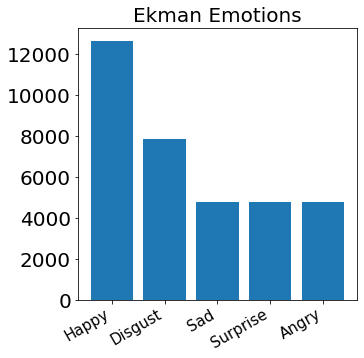

In [6]:
temp = stats_df[stats_df.emotion.isin(ekman)]
temp.emotion = temp.emotion.replace({'Smiling':'Happy'})
temp = temp.sort_values(by='count', ascending=False)
plt.figure(figsize=(5,5))
plt.bar(range(len(temp)), temp['count']) 
_ = plt.xticks(range(len(temp)), temp['emotion'], rotation=30, fontsize=15, horizontalalignment='right')
_ = plt.yticks(fontsize=20)
_ = plt.title('Ekman Emotions', fontsize=20)

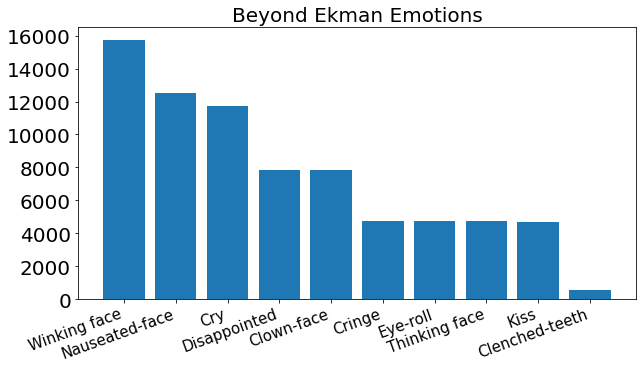

In [7]:
temp = stats_df[~stats_df.emotion.isin(ekman)]
temp.emotion = temp.emotion.replace({'Smiling':'Happy'})
temp = temp.sort_values(by='count', ascending=False)
plt.figure(figsize=(10,5))
plt.bar(range(len(temp)), temp['count']) 
_ = plt.xticks(range(len(temp)), temp['emotion'], rotation=20, fontsize=15,horizontalalignment='right')
_ = plt.yticks(fontsize=20)
_ = plt.title('Beyond Ekman Emotions', fontsize=20)

# Define dataset

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class emotionDataset(Dataset):
    def __init__(self, df, transforms=None, num_repeats=1, im_size=112):
        self.labels = np.array(df.label).astype(np.int64)
        self.emotions = np.array(df.emotion)
        self.addresses = np.array(df.address)        
        self.transforms = transforms
        self.num_repeats = num_repeats
        self.im_size = (im_size,im_size)
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Select sample
        label = self.labels[idx] 
        if self.num_repeats > 1 : 
            label = [self.labels[idx]]*self.num_repeats
            images = []
            
        address = self.addresses[idx]
        emotion = self.emotions[idx]
        
        
        image = Image.open(address)
        image = image.resize(self.im_size)
        image = np.array(image, dtype=np.uint8)[:,:,:3]
        
        assert image.max()>1
        
        if self.transforms:
            if self.num_repeats>1:
                for _ in range(self.num_repeats):
                    images.append(self.transforms(image=image)['image'])
                return torch.stack(images), torch.tensor(label)
            else:
                image = self.transforms(image=image)['image']
                
        return image, label
    
def collate_fn(batch):
    images, labels = tuple(zip(*batch))
    labels = [torch.tensor(x) for x in labels]
    return torch.stack(images).view(-1,*images[0].shape[-3:]), torch.stack(labels).view(-1)

# Transforms

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Declare an augmentation pipeline
training_transforms = A.Compose([
    
    A.augmentations.geometric.transforms.Perspective(scale=0.1, keep_size=True, pad_mode=cv2.BORDER_REFLECT, fit_output=True, interpolation=1, p=1),
    
    A.OneOf([
        A.Equalize(),
        A.ChannelDropout(),
        A.ChannelShuffle(),
        A.CLAHE(),
        A.ColorJitter(),
        A.RandomBrightnessContrast(),
        A.augmentations.transforms.ToGray(),
        A.ImageCompression(quality_lower=5, quality_upper=30),
        A.Downscale(scale_min=0.5, scale_max=0.5),
        A.CoarseDropout(max_holes=10, max_height=15, max_width=15),
        A.Sharpen (alpha=(0.2, 0.9), lightness=(0.1, 1.0)),
    ]),    
    
    A.OneOf([
        A.GaussianBlur(),
        A.Blur(),
        A.GlassBlur(sigma=0.5, max_delta=1, iterations=2),
        A.Emboss(alpha=(0.2, 0.9)),
        A.MedianBlur(blur_limit=7),
        A.MotionBlur(),
    ]),    

    A.HorizontalFlip(),    
    A.Normalize(max_pixel_value=255., always_apply=True),
    ToTensorV2(),
    
])

test_transforms = A.Compose([
    A.Normalize(max_pixel_value=255., always_apply=True),
    ToTensorV2()
])


# Early stopping class

In [10]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, folder, patience=20, verbose=True, delta=0, by='acc'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.early_stopped_before = 0
        if by == 'acc':
            self.val_loss_min = 0
        else:
            self.val_loss_min = np.Inf
        self.by = by
        self.delta = delta
        self.folder = folder
        self.stats_file = f'./{self.folder}/training_{self.folder.split("/")[-1]}.txt'

    def __call__(self, val_loss, model):
        
        if self.by == 'acc':
            score = val_loss
        else:
            score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score - self.delta:
            self.counter += 1
            message = f'EarlyStopping counter: {self.counter} out of {self.patience}'
            print(message)
            with open(self.stats_file, 'a') as stats_file:
                stats_file.write(f'{message} \n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, params):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            if self.by == 'acc':
                message = f'Validation accuracy increased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...'
            else:
                message = f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...'
                
        print(message)
        with open(self.stats_file, 'a') as stats_file:
            stats_file.write(f'{message} \n')
            
        torch.save(params, f'{self.folder}/checkpoint.pt')
        self.val_loss_min = val_loss


# Model definition

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models
from InsightFace_Pytorch.model import MobileFaceNet, Backbone
from InsightFace_Pytorch.config import get_config

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
        
class emotionClassifier(nn.Module):
    def __init__(self,in_channels = 3, input_dim = 128, latent_dim = 256, output_dim = 7, arch = 'mobilenet', freeze=False, num_linear=2, activation='PReLU', dropout=0.3, **kwargs):
        super(emotionClassifier, self).__init__()
        self.arch = arch
        scale = 1
   
        if 'resnet' in arch:
            backbone = eval(f'models.{arch}(pretrained=True)')
            feat_dim = backbone.fc.in_features
            self.backbone = torch.nn.Sequential(*list(backbone.children())[:-1], 
                                                Flatten())
        elif arch == 'mobilenet':
            backbone = models.mobilenet_v2(pretrained=True)
            feat_dim = backbone.classifier[1].in_features
            self.backbone = torch.nn.Sequential(backbone.features, 
                                                nn.ReLU(inplace=True),
                                                nn.AdaptiveAvgPool2d((1, 1)),
                                                Flatten())            
        else:
            return None
        
        dims = [feat_dim * scale]
        for i in range(num_linear):
            if i == 0:
                dims = dims + [latent_dim]
            else:
                dims = dims + [dims[-1]//2]
            
        layers = [nn.Dropout(dropout)]
        for i in range(num_linear):
            layers.extend([nn.Linear(dims[i], dims[i+1]), eval(f'nn.{activation}()'), nn.Dropout(dropout)])
        layers.append(nn.Linear(dims[-1], output_dim))
        self.fc = torch.nn.Sequential(*layers)
        
        
    def forward(self, x):
        x = self.backbone(x)        
        return self.fc(x)

    def loss_function(self, logits, target, weight=None, ls=0., focal=False):
        loss = F.cross_entropy(logits, target, weight=weight, label_smoothing=ls, reduction='none')
        if focal:
            log_softmax = F.log_softmax(logits, dim=1)
            softmax = torch.exp(log_softmax)
            loss *= (1 - torch.gather(softmax, 1, target.unsqueeze(1)).squeeze())**2
        return loss.mean()
    
    
# Tests
for arch in ['resnet50', 'mobilenet']:
    model = emotionClassifier(arch=arch, num_linear=1)
    model.eval()
    temp = torch.rand(4,3,128,128)
    for i in tqdm(range(5)):
        with torch.no_grad():
            model(temp).shape

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
from collections import defaultdict
from tqdm.notebook import tqdm
import torch.backends.cudnn as cudnn
from sklearn.metrics import accuracy_score, f1_score
import shutil
import skimage
import json
from skimage import exposure
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cudnn.deterministic = False
cudnn.benchmark = True

# Hyperparams
hyperparams = {
    'model_name_suffix' : 'tiktok',
    
    # Global settings
    'in_channels': 3,
    'input_dim': 112,
    'output_dim': len(global_emotions),
    'num_train_repeats': 1,
    'num_test_repeats': 1,
    
    # Training details
    'print_every' : 500, 
    'batch_size' : 128,
    'window' : 5,
    'patience' : 5,
    'early_stop_by' : 'acc',
    
    # Loss function
    'weight_decay' : 5e-4,
    'weighted_loss' : False,
    'focal_loss' : False,
    'label_smoothing' : 0.0,

    # Model
    'arch' : 'resnet50',
    'num_linear': 2,
    'latent_dim' : 512,
    'activation' : 'ReLU',
    'dropout' : 0.3,
    
    # Optimizer
    'optimizer' : 'Adam',
    'momentum' : 0.9, # for sgd
    
    # Scheduler
    'num_epochs' : 100,
    'learning_rate' : 1e-3, # initial learning rate
    'scheduler' : None,
        # Explonential
        'lr_gamma' : 0.99,

        # Cosine annealing
        'T_0' : 20,
        'T_mult' : 2,
        'learning_rate_denom' : 10,
}

if hyperparams['weighted_loss']:
    try:
        weights = torch.tensor(weights.astype(np.float32)).to(device)
    except:
        pass
else:
    weights = None

# Experiment name
name = f'{hyperparams["arch"]}_{hyperparams["model_name_suffix"]}'

# Prepare loaders
train_loader_params = {'batch_size':hyperparams['batch_size'],
                 'shuffle':True,
                 'num_workers':8,
                 'pin_memory':True
}

val_loader_params = {'batch_size':hyperparams['batch_size']*4,
                 'shuffle':False,
                 'num_workers':8,
                 'pin_memory':True
}


print('Creatings datasets and loaders')
train_dataset = emotionDataset(train_df, transforms=training_transforms, num_repeats=hyperparams['num_train_repeats'], im_size=hyperparams['input_dim'])
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn,  **train_loader_params)

val_dataset = emotionDataset(val_df, transforms=test_transforms, num_repeats=hyperparams['num_test_repeats'], im_size=hyperparams['input_dim'])
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, **val_loader_params)

# Sanity checks
assert train_dataset[0] and val_dataset[0]
images, labels = next(iter(train_dataloader))
assert images.shape[0] == hyperparams['batch_size']*hyperparams['num_train_repeats']
assert images.shape[-1] == hyperparams['input_dim']

if os.path.exists(f'runs/{name}'):
    shutil.rmtree(f'runs/{name}')
os.makedirs(f'runs/{name}')

with open(f'runs/{name}/hyperparams.json', 'w') as outfile:
    outfile.write(json.dumps(hyperparams, indent=4, sort_keys=True))

print(f'Experiment {name} ready...')

Creatings datasets and loaders
Experiment resnet50_tiktok ready...


In [ ]:
torch.cuda.empty_cache()

# Instantiate the model
model = emotionClassifier(**hyperparams)
model = model.to(device)

# Separate weight decay and other params
wd_modules = ['Conv2d', 'Linear']
other_modules = ['BatchNorm2d', 'PReLU']
wd_params = []
other_params = []
for module_name,module in model.named_modules():
    if module.__class__.__name__ in wd_modules:
        if module.weight is not None:
            wd_params.append(module.weight)
        if hasattr(module, 'bias'):  
            if module.bias is not None:
                other_params.append(module.bias)
        
    elif module.__class__.__name__ in other_modules:
        if module.weight is not None:
            other_params.append(module.weight)
        
        if hasattr(module, 'bias'):
            if module.bias is not None:
                other_params.append(module.bias)
    
# Create optimizer
params = [{'params': wd_params, 'weight_decay': hyperparams['weight_decay']},
          {'params': other_params}]

if hyperparams['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(params=params, lr=hyperparams['learning_rate'])
elif hyperparams['optimizer'] == 'Adam':
    optimizer = torch.optim.Adam(params=params, lr=hyperparams['learning_rate'])
elif hyperparams['optimizer'] == 'SGD':
    optimizer = torch.optim.SGD(params=params, lr=hyperparams['learning_rate'], momentum=hyperparams['momentum'], nesterov=True)

# Create scheduler
if hyperparams['scheduler'] == 'ExponentialLR':
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=hyperparams['lr_gamma'])
elif hyperparams['scheduler'] == 'CosineAnnealingWarmRestarts':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                     T_0=hyperparams['T_0'], 
                                                                     eta_min=hyperparams['learning_rate']/hyperparams['learning_rate_denom'], 
                                                                     T_mult=hyperparams['T_mult'])
else:
    scheduler = None
    
    
# tensorboard
writer = SummaryWriter(f'runs/{name}')

# Early stopping tracker
early_stopping = EarlyStopping(f'runs/{name}', patience=hyperparams['patience'], by=hyperparams['early_stop_by'])

#training loop
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
train_loss = 0.
preds = []
gts = []

In [ ]:
print('Training begins ...')
for epoch in tqdm(range(hyperparams['num_epochs'])):
    
    for step, (inputs, labels) in enumerate(tqdm(train_dataloader, leave=False)):
        model.train()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad(set_to_none=True)
        logits = model(inputs)
        loss = model.loss_function(logits, labels, weight=weights, focal=hyperparams['focal_loss'], ls=hyperparams['label_smoothing'])
        loss.backward()
        optimizer.step()
        
        preds.append(logits.detach().cpu().numpy())
        gts.append(labels.detach().cpu().numpy())
        train_loss = train_loss + loss.detach().cpu().numpy()
        
    
        if (step+1+epoch*len(train_dataloader)) % hyperparams['print_every'] == 0:
            train_loss /= hyperparams['print_every']

            train_loss_list.append(train_loss)
            preds = np.concatenate(preds)
            gts = np.concatenate(gts)
            train_acc = accuracy_score(gts,preds.argmax(axis=1))
            train_f1 = f1_score(gts,preds.argmax(axis=1), average='macro')
            train_acc_list.append(train_acc)
            model.eval()
            valid_loss = 0.
            preds = []
            gts = []
            for inputs, labels in tqdm(val_dataloader, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    logits = model(inputs)
                loss = model.loss_function(logits, labels, weight=weights, focal=hyperparams['focal_loss'], ls=hyperparams['label_smoothing'])
                preds.append(logits.detach().cpu().numpy())
                gts.append(labels.detach().cpu().numpy())
                valid_loss = valid_loss + loss.detach().cpu().numpy()


            preds = np.concatenate(preds)
            gts = np.concatenate(gts)
            valid_loss /= len(val_dataloader)
            valid_acc = accuracy_score(gts,preds.argmax(axis=1))
            valid_f1 = f1_score(gts,preds.argmax(axis=1), average='macro')
            val_loss_list.append(valid_loss)
            val_acc_list.append(valid_acc)

            message = 'Step {} --> Train loss: {:.6}, acc:{:.6}, f1(macro): {:.6} || Valid loss: {:.6}, acc: {:.6}, f1(macro): {:.6}'\
                      .format(step+1+epoch*len(train_dataloader), 
                              str(train_loss),
                              str(train_acc),
                              str(train_f1),
                              str(valid_loss), 
                              str(valid_acc),
                              str(valid_f1))
            print(message)

            writer.add_scalar("Loss/train", train_loss, step+1+epoch*len(train_dataloader))
            writer.add_scalar("Loss/valid", valid_loss, step+1+epoch*len(train_dataloader))
            writer.add_scalar("Acc/train", train_acc, step+1+epoch*len(train_dataloader))
            writer.add_scalar("Acc/valid", valid_acc, step+1+epoch*len(train_dataloader))
            writer.add_scalar("F1/train", train_f1, step+1+epoch*len(train_dataloader))
            writer.add_scalar("F1/valid", valid_f1, step+1+epoch*len(train_dataloader))
            writer.add_scalar("learning_rate", optimizer.param_groups[0]['lr'], step+1+epoch*len(train_dataloader))
            for param_name,param in model.named_parameters(): 
                if param_name in target_params:
                    writer.add_histogram(param_name, param, step+1)    
            
            with open(f'./runs/{name}/training_{name}.txt', 'a') as stats_file:
                stats_file.write(f'{message} \n')

            # Early stopping
            early_stopping(valid_f1, model.state_dict())

            if early_stopping.early_stop:
                break

            train_loss = 0.
            preds = []
            gts = []
            if scheduler:
                scheduler.step()
    if early_stopping.early_stop:
        break
writer.flush()


In [ ]:
# Ekman

# Experiment name
name = 'resnet50_tiktok'

# Load weights
folder = f'runs/{name}'
hyperparams = json.load(open(f'{folder}/hyperparams.json','r'))
model = emotionClassifier(**hyperparams)
model.load_state_dict(torch.load(f'{folder}/checkpoint.pt'))
model.to(device)
model.eval()

val_loader_params = {'batch_size':hyperparams['batch_size'],
                 'shuffle':False,
                 'num_workers':8,
                 'pin_memory':True
}

conv_dict = dict(zip(tiktok_df.emotion, tiktok_df.label))
ekman_idx = np.array([conv_dict[x] for x in ekman])

test_dataset = emotionDataset(val_df, transforms=test_transforms, num_repeats=hyperparams['num_test_repeats'])
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, **val_loader_params)

test_loss = 0.
ctr = 0
preds = []
gts = []
max_logits = []
logits_list = []
embeds = []
for inputs, labels in tqdm(test_dataloader):

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = model(inputs)
    logits = logits.view(-1,hyperparams['num_test_repeats'],hyperparams['output_dim']).max(1).values
    logits = logits[:,ekman_idx]
    logits_list.append(logits.detach().cpu().numpy())
    preds.append(F.softmax(logits, dim=1).detach().cpu().numpy())
    gts.append(labels.detach().cpu().numpy())

# max_logits = np.concatenate(max_logits)
preds = np.concatenate(preds)#.argmax(axis=1)
preds = ekman_idx[preds.argmax(axis=1)]
gts = np.concatenate(gts)
# embeds = np.concatenate(embeds)
logits = np.concatenate(logits_list)

print(f'f1 (macro): {f1_score(preds, gts, average="macro")}, accuracy : {accuracy_score(preds, gts)}')


In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
# Rows are truth, columns are preds

plt.figure(figsize=(9,7))
cm = confusion_matrix(gts,preds).astype(float)
cm = (cm.T / cm.sum(1)).T
plt.figure(figsize=(15,10))
fig = sn.heatmap(cm, xticklabels=ekman, yticklabels=ekman)
plt.xlabel('prediction', fontsize=15)
plt.ylabel('ground truth', fontsize=15)
plt.title('confusion matrix', fontsize=25)

_ = fig.set_xticklabels(fig.get_xticklabels(),rotation = 45, horizontalalignment='right', fontsize=20)
_ = fig.set_yticklabels(fig.get_yticklabels(), fontsize=20,rotation = 0)